In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
import torch.utils.data as data
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
torch.cuda.empty_cache()
import os
import glob
import gc
gc.collect()
torch.manual_seed(42)
device = torch.device("cuda:0")
# torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.set_default_tensor_type('torch.cuda.FloatTensor')


In [2]:
!nvidia-smi

Tue Dec 14 17:23:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:

tsne = TSNE(n_components=2,perplexity=20)

file_name = "/content/drive/MyDrive/RA/CNS_99_RA_scratch_transform_512.pth"
TRAIN_DATA_PATH = "/content/drive/MyDrive/RA/"
BATCH_SIZE = 4
LEARNING_RATE = 0.003
EPOCHS = 25
# mean, stf = get_mean_and_std(train_iter_loader) #We call this function after initializing the dataloader
mean = [0.8249, 0.8083, 0.8291]#calculated using the function above
std = [0.1698, 0.1917, 0.1764]#calculated using the fucntion above
TRANSFORM_IMG_train = transforms.Compose([
    transforms.Resize((512,512)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.RandomVerticalFlip(),
    # transforms.Resize(256),
    # transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
TRANSFORM_IMG_test = transforms.Compose([
    transforms.Resize((512,512)),
    # transforms.Resize(256),
    # transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])


In [4]:

# file_list = glob.glob('data/train/'+ "*")

# file_list

# counter = 0
# for folder in file_list:
#     files = glob.glob( folder+ "/*.tif")
#     counter+=len(files)
    

# counter


In [5]:

train_iter_folder = torchvision.datasets.ImageFolder(os.path.join(TRAIN_DATA_PATH, 'train'), transform=TRANSFORM_IMG_train)
# train_iter_folder = torchvision.datasets.ImageFolder(os.path.join(TRAIN_DATA_PATH, 'train'))
train_iter_loader = DataLoader(train_iter_folder,batch_size = 25,shuffle=True,generator=torch.Generator(device='cuda'))

classes = {'colon': 0,'endometrium_1': 1,'endometrium_2': 2,'kidney': 3,
'liver': 4,'lung': 5,'lymph_node': 6,'pancreas': 7,'skin_1': 8,'skin_2': 9,'small_intestine': 10,'spleen': 11}

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*125*125,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3  = nn.Linear(84,len(classes))

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*125*125)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [6]:

net = CNN()

net.to(device)
net.cuda()


CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=250000, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=12, bias=True)
)

In [59]:

net.load_state_dict(torch.load(file_name))
test_imgs = torch.zeros((0, 1, 512, 512),device = torch.device("cuda:0"))
test_predictions = []
test_targets = []
test_embeddings = torch.zeros((0, 12), device = torch.device("cuda:0"))

for i,(images,labels) in enumerate(train_iter_loader):
    x = images.to(device)
    y = labels.to(device)
    embeddings = net(x)
    x = x.cpu()
    # print(embeddings,embeddings.shape)
    preds = torch.argmax(embeddings, dim=1)
    test_predictions.extend(preds.detach().cpu().tolist())
    test_targets.extend(y.detach().cpu().tolist())
    test_embeddings = torch.cat((test_embeddings, embeddings.detach()), 0)
    # test_imgs = torch.cat((test_imgs, x.detach()), 0)
# test_imgs = np.array(test_imgs)


In [8]:
test_embeddings = np.array(test_embeddings.cpu())
test_targets = np.array(test_targets)
test_predictions = np.array(test_predictions)

In [9]:
test_embeddings

array([[ 5.43069458e+00, -3.43238831e+00, -3.08788514e+00, ...,
        -3.01660609e+00, -2.49243043e-02, -9.11542702e+00],
       [ 3.91636658e+01, -1.33993759e+01,  8.14840555e-01, ...,
         1.77587738e+01, -1.23486400e+00, -2.43769188e+01],
       [ 8.16653633e+00, -1.13896179e+00,  1.14476430e+00, ...,
         1.13382778e+01, -5.62083185e-01, -1.19618025e+01],
       ...,
       [ 1.94095116e+01, -4.51573277e+00, -2.74585032e+00, ...,
         3.39666456e-01,  6.04784870e+00, -1.42562065e+01],
       [ 1.06112490e+01, -3.08733726e+00,  5.97680926e-01, ...,
         7.07407570e+00, -1.06485263e-01, -1.28866053e+01],
       [ 5.36973619e+00, -6.85183239e+00,  4.75234568e-01, ...,
        -3.53148055e+00, -4.61770487e+00, -1.46516027e+01]], dtype=float32)

In [11]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.010s...
[t-SNE] Computed neighbors for 1200 samples in 0.084s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 5.562230
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.330742
[t-SNE] KL divergence after 1000 iterations: 0.633603


In [12]:
import seaborn as sns

In [13]:
tsne_proj

array([[-44.41483  ,  -7.206876 ],
       [-31.440714 , -30.678278 ],
       [-18.714132 ,  -3.2258086],
       ...,
       [-22.567513 , -31.84023  ],
       [-29.030884 , -24.165453 ],
       [-21.462877 , -15.366705 ]], dtype=float32)

In [54]:
# plt.figure(figsize=(10,10))
# for i in range(len(classes_list)):
#   sns.scatterplot(tsne_proj[:,0],tsne_proj[:,1],label=classes_list[i],c = test_targets)
#   # ax.scatter(x, y, c=color, s=scale, label=color,
#   #              alpha=0.3, edgecolors='none')

In [27]:
test_targets

array([5, 0, 9, ..., 0, 0, 8])

In [28]:
train_iter_folder.class_to_idx

{'colon': 0,
 'endometrium_1': 1,
 'endometrium_2': 2,
 'kidney': 3,
 'liver': 4,
 'lung': 5,
 'lymph_node': 6,
 'pancreas': 7,
 'skin_1': 8,
 'skin_2': 9,
 'small_intestine': 10,
 'spleen': 11}

In [26]:
classes_list = train_iter_folder.classes

In [30]:
classes_list_array = np.array([classes_list[i] for i in test_targets])

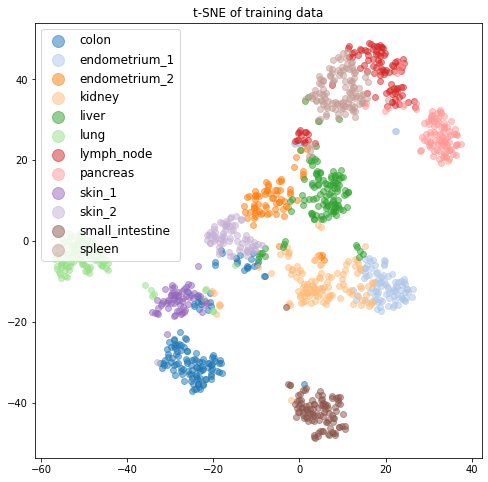

In [58]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 12
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5,)
ax.legend(fontsize='large', markerscale=2,labels=classes_list)
plt.title('t-SNE of training data')
plt.show()

In [60]:
!nvidia-smi

Tue Dec 14 18:21:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    78W / 149W |   2136MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [63]:
test_iter_folder = torchvision.datasets.ImageFolder(os.path.join(TRAIN_DATA_PATH, 'test'), transform=TRANSFORM_IMG_test)
# train_iter_folder = torchvision.datasets.ImageFolder(os.path.join(TRAIN_DATA_PATH, 'train'))
test_iter_loader = DataLoader(train_iter_folder,batch_size = 25,shuffle=True,generator=torch.Generator(device='cuda'))

T-SNE on test Data

In [64]:
test_imgs = torch.zeros((0, 1, 512, 512),device = torch.device("cuda:0"))
test_predictions = []
test_targets = []
test_embeddings = torch.zeros((0, 12), device = torch.device("cuda:0"))

for i,(images,labels) in enumerate(test_iter_loader):
    x = images.to(device)
    y = labels.to(device)
    embeddings = net(x)
    x = x.cpu()
    # print(embeddings,embeddings.shape)
    preds = torch.argmax(embeddings, dim=1)
    test_predictions.extend(preds.detach().cpu().tolist())
    test_targets.extend(y.detach().cpu().tolist())
    test_embeddings = torch.cat((test_embeddings, embeddings.detach()), 0)


In [65]:
test_embeddings = np.array(test_embeddings.cpu())
test_targets = np.array(test_targets)
test_predictions = np.array(test_predictions)

In [67]:
test_embeddings

array([[ 5.43069458e+00, -3.43238831e+00, -3.08788514e+00, ...,
        -3.01660609e+00, -2.49243043e-02, -9.11542702e+00],
       [ 3.91636658e+01, -1.33993759e+01,  8.14840555e-01, ...,
         1.77587738e+01, -1.23486400e+00, -2.43769188e+01],
       [ 8.16653633e+00, -1.13896179e+00,  1.14476430e+00, ...,
         1.13382778e+01, -5.62083185e-01, -1.19618025e+01],
       ...,
       [ 1.94095116e+01, -4.51573277e+00, -2.74585032e+00, ...,
         3.39666456e-01,  6.04784870e+00, -1.42562065e+01],
       [ 1.06112490e+01, -3.08733726e+00,  5.97680926e-01, ...,
         7.07407570e+00, -1.06485263e-01, -1.28866053e+01],
       [ 5.36973619e+00, -6.85183239e+00,  4.75234568e-01, ...,
        -3.53148055e+00, -4.61770487e+00, -1.46516027e+01]], dtype=float32)

In [68]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.005s...
[t-SNE] Computed neighbors for 1200 samples in 0.045s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 5.562230
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.324978
[t-SNE] KL divergence after 1000 iterations: 0.625312


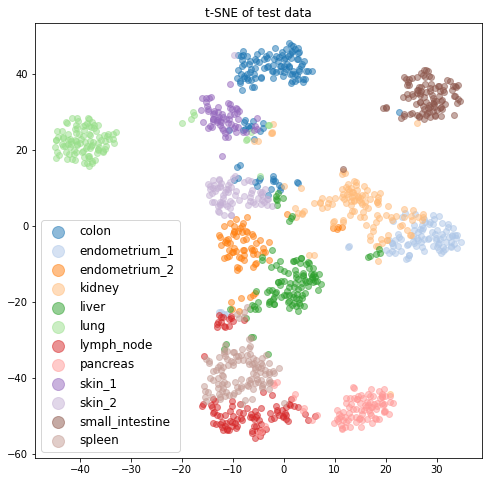

In [70]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 12
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5,)
ax.legend(fontsize='large', markerscale=2,labels=classes_list)
plt.title('t-SNE of test data')
plt.show()